# Regression

###### COMP4670/8600 - Statistical Machine Learning - Tutorial

In this lab, we will use linear regression to predict the value of a home and explore the impact of regularisation. While this lab is not particularly challenging, we highly recommend collaborating in pairs. The presence of numerous discussion questions provides an opportunity for fruitful interaction, enhancing your overall understanding of the topic.

### Assumed knowledge
- Maximum likelihood solution to a linear regression problem, with and without regularisation (lectures, section 3 in Bishop)
- Matrix calculations in numpy (lab 00b-matrix)

### After this lab, you should be comfortable with:
- Practical linear regression problems
- Picking an appropriate regularisation parameter for a given problem

### Overview of this Notebook:
#### 1.  Regression without regularisation
- 1.1 Maximum likelihood solution
- 1.2 Training and testing
- 1.3 Interpreting the model

#### 2. Regression with regularisation
- 2.1 Maximum likelihood solution
- 2.2 Effect of regularisation
- 2.3 Picking a regularisation parameter

#### 3. Basis function
- 3.1 Implementation of polynomial basis function
- 3.2 Effect of applying polynomial basis function

$\newcommand{\trace}[1]{\operatorname{tr}\left\{#1\right\}}$
$\newcommand{\Norm}[1]{\lVert#1\rVert}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\inner}[2]{\langle #1, #2 \rangle}$
$\newcommand{\DD}{\mathscr{D}}$
$\newcommand{\grad}[1]{\operatorname{grad}#1}$
$\DeclareMathOperator*{\argmin}{arg\,min}$

Setting up the environment

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Dataset used in this lab
In this lab, we will use `01-dataset.csv` on the price of housing in Boston (see [description](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)).
We aim to predict the house price based on various influencing factors.
In this dataset, each row represents one house. The first entry is the value of the house and we will predict it from the remaining values which have been normalised to be in the range $[-1, 1]$. The column labels are

```'medv', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat'```

In the below cell we load the dataset. To read in the data, we use ```np.loadtxt``` (see [manual](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html)) with the optional argument ```delimiter=','```, as our data is comma separated rather than space separated. Then we remove the column containing the binary variable ```'chas'```.

In [2]:
# Load data with column labels
names = ['medv', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']
loaded_data = np.loadtxt('01-dataset.csv', delimiter=',')

# remove chas
column_idxes = list(range(len(names)))
chas_idx = names.index('chas')
wanted_columns = list(column_idxes)
wanted_columns.remove(chas_idx)
data = loaded_data[:,wanted_columns]
data_names = list(names)
data_names.remove('chas')

The data has 506 rows (examples) and 13 columns (1 label and 12 features).

In [3]:
print(data_names)
print(np.array_str(data[:5], precision=3))
assert data.shape == (506,13), data.shape

['medv', 'crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']
[[24.    -1.    -0.64  -0.864 -0.37   0.155  0.283 -0.462 -1.    -0.584
  -0.426  1.    -0.821]
 [21.    -1.    -1.    -0.515 -0.654  0.096  0.565 -0.302 -0.913 -0.79
   0.106  1.    -0.591]
 [34.    -1.    -1.    -0.515 -0.654  0.389  0.199 -0.302 -0.913 -0.79
   0.106  0.979 -0.873]
 [33.    -0.999 -1.    -0.874 -0.7    0.317 -0.116 -0.103 -0.826 -0.866
   0.298  0.989 -0.933]
 [36.    -0.999 -1.    -0.874 -0.7    0.374  0.057 -0.103 -0.826 -0.866
   0.298  1.    -0.801]]


## 1. Regression without regularisation
### 1.1. Maximum likelihood solution
From the lecture, we learn that maximizing the likelihood (MLE) is mathematically equivalent to minimizing the empirical risk (ERM). Try to convince yourself why this is true.

Now your task is to implement a function to find the maximum likelihood solution $w_{ML}$ assuming Gaussian noise for this linear regression problem, where the cost function is set as the sum-of-squares error (SSE).

**Hint: you could directly use the result from section (3.15) in Bishop.**

In [6]:
def w_ml_unregularised(Phi, t):
    # Phi: Features (N,D), t: Targets (N,)
    # returns w_ml_unregularised (D,)
    ### IMPLEMENTED
    return np.linalg.inv(np.transpose(Phi) @ Phi) @ np.transpose(Phi) @ t

### 1.2. Training and testing

Use 20% of the available data for training the model using maximum likelihood. The rest of the data is used for testing. Report the root mean squared error (RMSE) for both training set and the test set.
In this cases, for simplicity, we use the identity map as the basis function, $\phi(x)=x$. We will evaluate the effect when we use other basis functions later in Question 3.

Note that the data may be sorted or ordered in some way we cannot predict. How will you account for this?

**Hint: consider shuffling the data before we split the dataset into training and testing sets.**

In [7]:
def split_data(data):
    """Randomly split data into two groups. The first group is a fifth of the data."""
    np.random.seed(42)
    N = len(data)
    idx = np.arange(N)
    np.random.shuffle(idx)
    ### TODO: implement a strategy to extract indices for training and testing instances.
    train_idx, test_idx = idx[:int(N/5)], idx[int(N/5):] # 20% for training
    # don't forget to shuffle the data before we split the data

    # Labels are stored in the first column
    X_train = data[train_idx, 1:]
    t_train = data[train_idx, 0]
    X_test = data[test_idx, 1:]
    t_test = data[test_idx, 0]

    return X_train, t_train, X_test, t_test

def rmse(X_train, t_train, X_test, t_test, w):
    """Return the RMSE for training and test sets"""
    N_train = len(X_train)
    N_test = len(X_test)

    def rmse_template(X, t, w):
        # Data: X (N,D)
        # Targets: t (N,)
        # Params: w (D,)

        ### TODO
        N = len(X)
        t_pred = np.dot(X, w)
        rmse = np.linalg.norm(t - t_pred) / np.sqrt(N)
        return rmse

    # Training error
    rmse_train = rmse_template(X_train, t_train, w)
    # Testing error
    rmse_test = rmse_template(X_test, t_test, w)

    return rmse_train, rmse_test

X_train, t_train, X_test, t_test = split_data(data)
w_unreg = w_ml_unregularised(X_train, t_train)

train_rmse, test_rmse = rmse(X_train, t_train, X_test, t_test, w_unreg)
print("RMSE without regularisation: Train {:.6f}, Test {:.6f}".format(train_rmse, test_rmse))

RMSE without regularisation: Train 4.502797, Test 5.823252


### 1.3 Interpreting the model

Find the feature with the biggest magnitude of weight. The below codes provide a plot with respect of this feature.

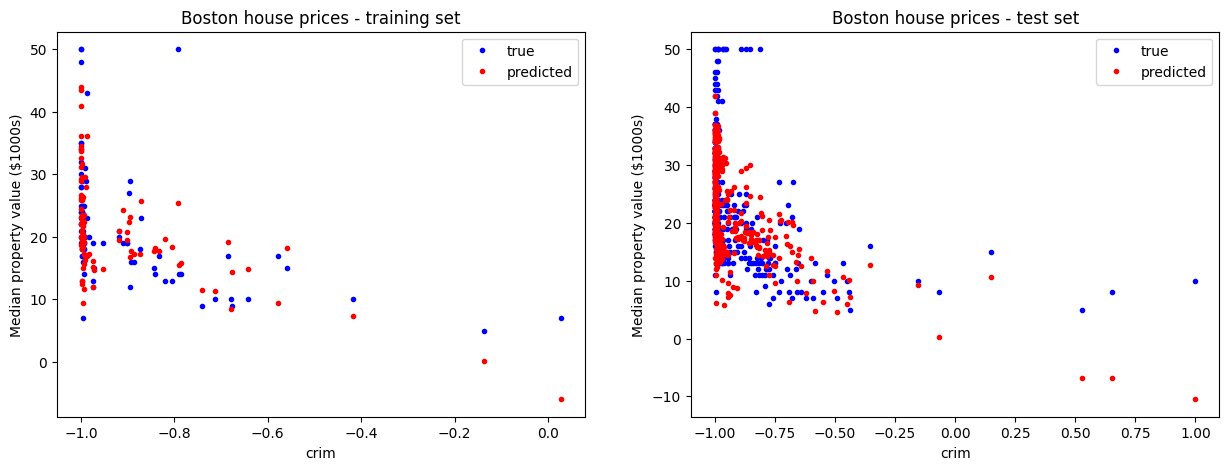

In [8]:
feature_names = data_names[1:]
max_feature = np.argmax(np.abs(w_unreg))
t_train_pred = np.dot(X_train, w_unreg)
t_test_pred = np.dot(X_test, w_unreg)

# Plotting Code
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
ax.plot(X_train[:,max_feature], t_train, 'b.', label='true')
ax.plot(X_train[:,max_feature], t_train_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - training set')
ax.set_xlabel(feature_names[max_feature])
ax.set_ylabel('Median property value ($1000s)')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(X_test[:,max_feature], t_test, 'b.', label='true')
ax.plot(X_test[:,max_feature], t_test_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - test set')
ax.set_xlabel(feature_names[max_feature])
ax.set_ylabel('Median property value ($1000s)')
ax.legend()
plt.show()

Discuss what do you observe. What do you know about the relationships between the feature with the biggest magnitute and the property values?

### <span style="color:blue">Answer</span>

The feature with the biggest magnitude is crim and correlates with the property value negatively, i.e. higher crim results in cheaper properties.

## 2. Regression with regularisation
### 2.1. Maximum likelihood solution
Implement a function to find the maximum likelihood solution $w_{reg}$ for some regularisation parameter $\lambda > 0$ assuming Gaussian noise for this linear regression problem. See section (3.1.4) in Bishop.

**Hint: It is always a good idea to use `np.eye` whenever we want an identity matrix. See [manual](https://numpy.org/devdocs/reference/generated/numpy.eye.html) here.**

In [10]:
def w_ml_regularised(Phi, t, l):
    """
    Calculates the maximum likelihood solution for linear regression with regularisation.

    Args:
        Phi: The design matrix (N, D).
        t: The target values (N,).
        l: The regularisation parameter (lambda).

    Returns:
        The regularised weight vector (D,).
    """
    D = Phi.shape[1]  # Number of features
    # Applying the formula from Bishop (3.15) with the regularisation term
    return np.linalg.inv(Phi.T @ Phi + l * np.eye(D)) @ Phi.T @ t

### 2.2 Effect of regularisation
By calculating the RMSE on the training and test sets, evaluate the impact of regularisation for $\lambda = 1.1$. What is the effect of regularisation?

**Hint: use `np.linalg.norm` to compare the magnitude of both versions of the learned weight.**

In [11]:
l=1.1
X_train, t_train, X_test, t_test = split_data(data)

# Without regularisation
w_unreg = w_ml_unregularised(X_train, t_train)
train_rmse_un, test_rmse_un = rmse(X_train, t_train, X_test, t_test, w_unreg)
print("RMSE without regularisation: Train {:.6f}, Test {:.6f}".format(train_rmse_un, test_rmse_un))

# With regularisation
w_reg = w_ml_regularised(X_train, t_train,l)

train_rmse, test_rmse = rmse(X_train, t_train, X_test, t_test, w_reg)
print("RMSE with regularisation: Train {:.6f}, Test {:.6f}".format(train_rmse, test_rmse))

### TODO: calculate the norm of w_unreg and w_reg
norm_unreg, norm_reg = np.linalg.norm(w_unreg), np.linalg.norm(w_reg)
print("Unregularised: {:.6f}, Regularised: {:.6f} ".format(norm_unreg, norm_reg))

RMSE without regularisation: Train 4.502797, Test 5.823252
RMSE with regularisation: Train 4.577969, Test 5.626987
Unregularised: 26.499727, Regularised: 23.697801 


Summarize what you could observe from the results above.

### <span style="color:blue">Answer</span>
The regularised model performs slightly worse on the training set (higher RMSE), but slightly better on the test set (lower RMSE). Including a regularisation term in the error function means the resulting model is less likely to overfit and therefore performs better on unseen test data.

Moreover, by examining the magnitudes of the weights in both versions—with and without the regularization term—it becomes evident that the inclusion of the regularization term results in lower weights. This observation implies a reduction in model complexity compared to the scenario without regularization. The regularization term acts as a constraint, penalizing overly complex models and promoting a more parsimonious representation, which can enhance the model's generalization performance.

### 2.3 Picking a regularisation parameter

The below code plots the RMSE on both training and test sets against the regularisation parameter $\log(\lambda)$ for a range of values of $\log(\lambda)$. Read the plot and answer the questions, also discuss with a partner on your observation:

1) When is the model under-regularising and over-regularising? How do you interpret the saturation when $\log(\lambda)$ is extremely large?

2) By looking at the second plot, can you identify what is the optimal value of $\log(\lambda)$?

3) Which value (train and test) is the evidence for your choice in 2) and why should you choose it over the other?

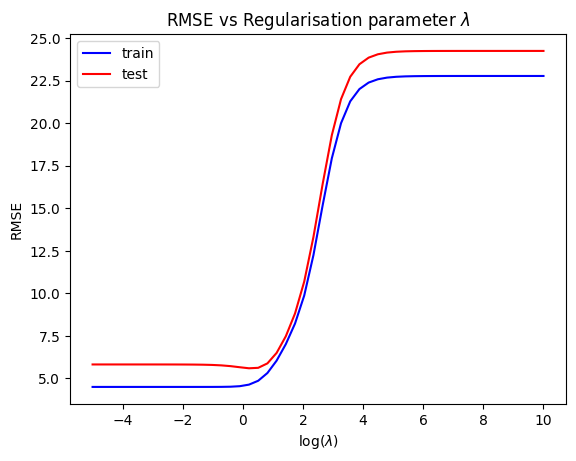

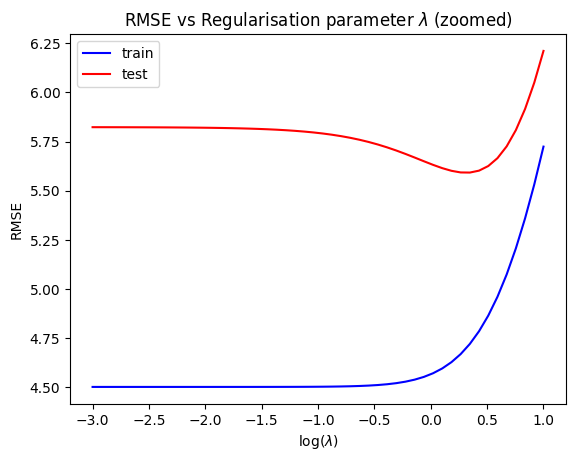

In [12]:
# Plotting codes (don't modify below)
log_lambdas = np.linspace(-5, 10)
# Each row is a value of lambda
# Columns are respectively ['rmse_train_linear', 'rmse_test_linear']
results = np.zeros((len(log_lambdas), 2))

for ix, l in enumerate(log_lambdas):
    rmse_train, rmse_test = rmse(X_train, t_train, X_test, t_test,
                                 w_ml_regularised(X_train, t_train, pow(10,float(l))))
    results[ix, 0] = rmse_train
    results[ix, 1] = rmse_test

#fig = plt.figure(figsize=(15,8))
plt.title('RMSE vs Regularisation parameter $\lambda$')
plt.plot(log_lambdas, results[:,0], 'b-', label='train') # training data
plt.plot(log_lambdas, results[:,1], 'r-', label='test') # test data
plt.xlabel('log($\lambda$)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Look closer at range(-3, 1)

log_lambdas = np.linspace(-3, 1)
# Each row is a value of lambda
# Columns are respectively ['rmse_train_linear', 'rmse_test_linear']
results = np.zeros((len(log_lambdas), 2))

for ix, l in enumerate(log_lambdas):
    rmse_train, rmse_test = rmse(X_train, t_train, X_test, t_test,
                                 w_ml_regularised(X_train, t_train, pow(10,float(l))))
    results[ix, 0] = rmse_train
    results[ix, 1] = rmse_test

plt.title('RMSE vs Regularisation parameter $\lambda$ (zoomed)')
plt.plot(log_lambdas, results[:,0], 'b-', label='train') # training data
plt.plot(log_lambdas, results[:,1], 'r-', label='test') # test data
plt.xlabel('log($\lambda$)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### <span style="color:blue">Answer</span>

1) It is under-regularising when $\log(\lambda)$ is small (close to 0), in which case the error is be similar to the unregularised cases since it will still be overfitting to the training data. It is over-regularising when $\log(\lambda)$ is large (roughly more than $\sqrt{10})$, then the model will be unable to learn more complex features as weights for the basis function becomes limited to the extreme of constant function. Therefore the performance remains constant as well. And the model might be underfitting.

2) Roughly when $\log(\lambda) = 0.25$.

3) RMSE on test set, since we wish the model to generalize on unseen data set during test phase, which is the intention of the regularisation.

## 3. Basis Functions
The observed results above suggest that using the identity function as the basis may oversimplify our house price prediction problem, potentially missing non-linear relationships among features. Features such as amenities, architecture, and location can contribute to complex patterns not adequately captured by a linear model. To address this, we propose exploring advanced basis functions, such as [polynomial kernels](http://en.wikipedia.org/wiki/Polynomial_kernel). These functions introduce higher-order terms, offering the flexibility needed to model intricate relationships and potentially improve predictive accuracy.

### 3.1 Implementation of polynomial basis function
Implement subroutines for polynomial basis function of degree 2.

**Hint: now that the basis function becomes $\Phi(x) = [1, x, x^2]$ where x is a single D-dimensional feature vector.**

In [13]:
def phi_quadratic(x):
    """Compute phi(x) for a single training example using quadratic basis function."""
    # x: Single feature vector (D,)
    # Returns quadratic feature vector ((D+1)*(D+2)/2,)

    D = len(x)
    # Features are (1, {x_i}, {cross terms and squared terms})
    # Cross terms x_i x_j and squared terms x_i^2 can be taken from upper triangle of outer product of x with itself
    return np.hstack((1, x, np.outer(x, x)[np.triu_indices(D)]))

### 3.2 Effect of applying polynomial basis function
Apply this to your train and test sets, and repeat the above exercise with these new features. Report what differences you see.

### Without Regularisation ###


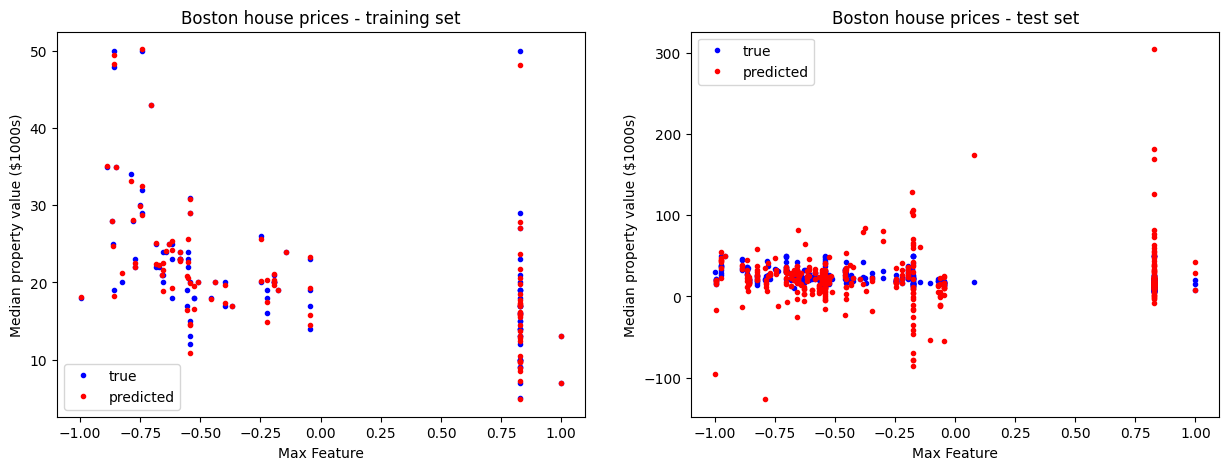

RMSE with basis functions and without regularisation: Train 1.005705, Test 32.604073

### With Regularisation ###


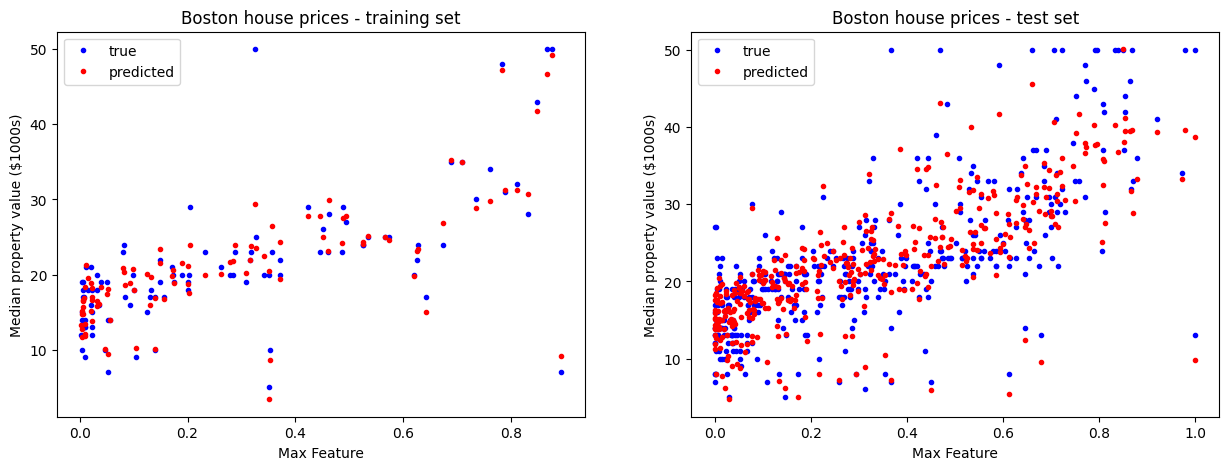

RMSE with basis functions and with regularisation: Train 2.902632, Test 3.784198



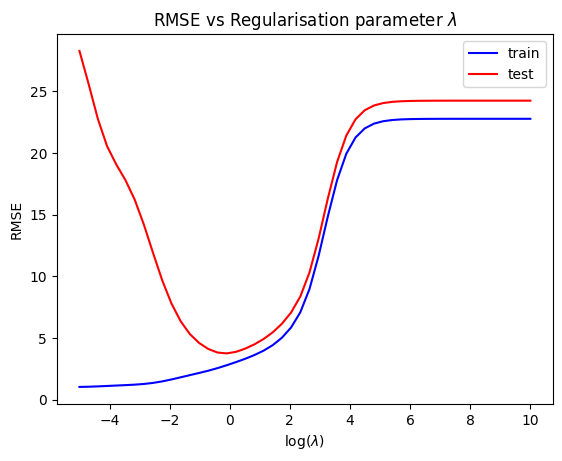

In [14]:
# Plotting codes (don't modify below)
# Without Regularisation
print("### Without Regularisation ###")

Phi_train = np.array([phi_quadratic(X_train[i]) for i in range(X_train.shape[0])])
Phi_test = np.array([phi_quadratic(X_test[i]) for i in range(X_test.shape[0])])

w_unreg = w_ml_unregularised(Phi_train, t_train)
max_feature = np.argmax(np.abs(w_unreg))
t_train_pred = np.dot(Phi_train, w_unreg)
t_test_pred = np.dot(Phi_test, w_unreg)
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
ax.plot(Phi_train[:,max_feature], t_train, 'b.', label='true')
ax.plot(Phi_train[:,max_feature], t_train_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - training set')
ax.set_xlabel("Max Feature")
ax.set_ylabel('Median property value ($1000s)')
x_vals = np.linspace(-1,1)
ax.legend()

ax = fig.add_subplot(122)
ax.plot(Phi_test[:,max_feature], t_test, 'b.', label='true')
ax.plot(Phi_test[:,max_feature], t_test_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - test set')
ax.set_xlabel("Max Feature")
ax.set_ylabel('Median property value ($1000s)')
ax.legend()
plt.show()

train_rmse, test_rmse = rmse(Phi_train, t_train, Phi_test, t_test, w_unreg)
print("RMSE with basis functions and without regularisation: Train {:.6f}, Test {:.6f}".format(train_rmse, test_rmse))
print()

# With Regularisation
print("### With Regularisation ###")

w_reg = w_ml_regularised(Phi_train, t_train, 1.1)
max_feature = np.argmax(np.abs(w_reg))
t_train_pred = np.dot(Phi_train, w_reg)
t_test_pred = np.dot(Phi_test, w_reg)
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
ax.plot(Phi_train[:,max_feature], t_train, 'b.', label='true')
ax.plot(Phi_train[:,max_feature], t_train_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - training set')
ax.set_xlabel("Max Feature")
ax.set_ylabel('Median property value ($1000s)')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(Phi_test[:,max_feature], t_test, 'b.', label='true')
ax.plot(Phi_test[:,max_feature], t_test_pred, 'r.', label='predicted')
ax.set_title('Boston house prices - test set')
ax.set_xlabel("Max Feature")
ax.set_ylabel('Median property value ($1000s)')
ax.legend()
plt.show()

train_rmse, test_rmse = rmse(Phi_train, t_train, Phi_test, t_test, w_reg)
print("RMSE with basis functions and with regularisation: Train {:.6f}, Test {:.6f}".format(train_rmse, test_rmse))
print()

# RMSE vs Regularisation curve

log_lambdas = np.linspace(-5, 10)
# Each row is a value of lambda
# Columns are respectively ['rmse_train_linear', 'rmse_test_linear']
results = np.zeros((len(log_lambdas), 2))

for ix, l in enumerate(log_lambdas):
    rmse_train, rmse_test = rmse(Phi_train, t_train, Phi_test, t_test,
                                 w_ml_regularised(Phi_train, t_train, pow(10,float(l))))
    results[ix, 0] = rmse_train
    results[ix, 1] = rmse_test

plt.title('RMSE vs Regularisation parameter $\lambda$')
plt.plot(log_lambdas, results[:,0], 'b-', label='train') # training data
plt.plot(log_lambdas, results[:,1], 'r-', label='test') # test data
plt.xlabel('log($\lambda$)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### <span style="color:blue">Answer</span>

The polynomial basis functions increase predictive power, but this makes the model more prone to overfitting. This can be seen by a vary low RMSE for the train set while a very high RMSE for the test set when no regularisation is used. This discrepancy signals that the model struggles to generalize to new, unseen data.

The introduction of regularization addresses this overfitting issue. Regularization imposes constraints on the model's complexity by penalizing large coefficients. From the plot, when regularisation is used the training RMSE increases but the test RMSE decreases dramatically.

In summary, the choice of the polynomial basis function of degree 2, coupled with regularization, strikes a balance between capturing intricate patterns and preventing overfitting. This highlights the importance of careful regularization in polynomial regression models to achieve robust and generalizable performance.